In [4]:
# set main directory name
dir = dirname(pwd());

In [5]:
using DifferentialEquations
using JumpProcesses
using Plots
# using PlotlyJS
using Statistics
using Distributions
using Random
using JLD2

using Optimization
using OptimizationOptimJL
# using BlackBoxOptim

using CSV
using DataFrames
using DelimitedFiles

# include own module with functionalities
include(joinpath(dir, "src/functionalities.jl"))

# set seed for reproducibility
Random.seed!(123);

## Compare treatment effects
In this notebook we consider the introduction of a treatment, that reduces thegrowth rate of the tumour. We do this in order to show that treatment effects can beidentified. We also introduce the BMI as a covariate on the growth rate and show that we also can quantify/identify that effect and also if it interacts with the treatment.

We do two experiments. Once treated vs untreated, with treatment occuring at a timepoint $T_{treat}$ and also then treated but having co-factor as obesity.

We will have three groups: Untreated, Treated with obesity, treated without obesity (obesity BMI>30).



## Exponential growth model
We will use the exponential growth model, but based on the new parametrization, we need to change our likelihoods. Maybe just numeric integration, to have faster results.

So we get as parameters $\beta_0$ as basal (untreated) growth rate, $\rho=0.9$ as reduction factor due to first treatment, and another multiplicative factor $1/\delta=0.5$ for the reduction of the treament by obesity.


We could also think about treatments that eliminate metastasic seeding? (But implicitly incorporated since that depends on tumour size).

In [6]:
# initial conditions
S0 = 0.065

beta0 = 0.5
rho = 0.45 # gets subtracted but here positive for log-scale ooptimization
delta = 0.2
m_basal = 0.01
m_size = 0.003

m_sigma = 0.03
m_order = 1.0

d_size = 0.001
d_metastasis = 0.002
θ = [beta0, rho, delta, m_basal, m_size, d_size, d_metastasis]
p = (beta0 = beta0, rho = rho, delta = delta, m_basal = m_basal, m_size = m_size, d_size = d_size, d_metastasis = d_metastasis)

treated_par_names = ["beta0", "rho", "delta", "m_basal", "m_size", "d_size", "d_metastasis"];

In [7]:
# get exponential tumour growth
function expgrowth!(du, u, p, t)
    du[1] = p[1]* u[1]
end

function TumourPaht(S0, p; endtime=30.0)
    prob = ODEProblem(expgrowth!, [S0], (0.0, endtime), [p.beta0])
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
    return sol
end

function TumorPathTreated(S0, p; BMI=20, treatment_time=nothing, endtime=30.0)
    if treatment_time != nothing
        # define callback to change parameter at treatment time
        prob = ODEProblem(expgrowth!, [S0], (0.0, endtime), [p.beta0])

        if BMI >= 30
           beta = p.beta0 - p.rho + p.delta
        else
           beta = p.beta0 - p.rho
        end
        
        condition(u, t, integrator) = t == treatment_time
        affect!(integrator) = integrator.p[1] = beta
        cb = ContinuousCallback(condition, affect!)
        sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, tstops = [treatment_time], callback=cb)
    else
        prob = ODEProblem(expgrowth!, [S0], (0.0, endtime), [p.beta0])
        sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
    end
    return sol
end

TumorPathTreated (generic function with 1 method)

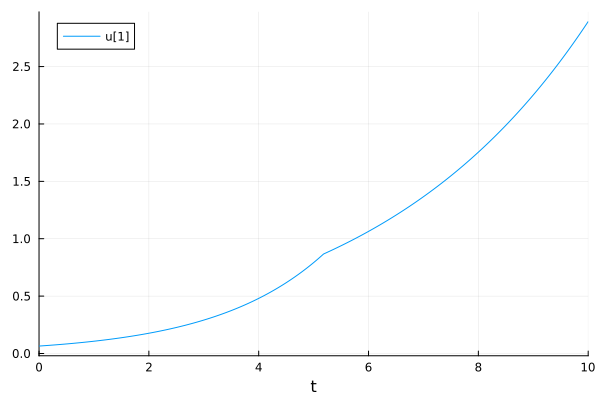

In [8]:
ex_path = TumorPathTreated(0.065, p, treatment_time=5.0, BMI = 30, endtime = 10.0);

plot(ex_path)

### Data Generation

We assume that at the start of the treatment we have one observation of the patient. And that BMI is observed and measured correctly.

In [9]:
include(joinpath(dir, "src/general_MNR_simulation_algorithm.jl"))

simulate_many_MNR (generic function with 1 method)

In [ ]:

function simulate_treatment_patients(p; npat = 200, endtime=30.0, S0=0.05, sigma = 0.1, rng = MersenneTwister(123))

    timepoints = 0.0:1.0:30.0

    # initialize data frame
    df = DataFrame(patient_id=Int64[], time=Float64[], tumor=Float64[], metastasis=Int64[], death=Int64[], treatment=Int64[], BMIt=Int64[])

    # loop over N simulations
    for i in 1:npat
        pat_id = i

        # sample BMI 
        BMI = rand(rng, 20:40)

        # sample if treatment and the treatment time
        treatment = rand(Bernoulli(0.5)) 
        if treatment == 1
            treatment_time = rand(rng, 0:20)
        else
            treatment_time = nothing
        end


        # get function for Tumor Growth ODE
        ODESol = TumorPathTreated(S0, p, BMI = BMI, treatment_time = treatment_time, endtime=endtime)

        try
            sim = single_MNR_simulation_proportional_intensity(p, ODESol, S0=S0, endtime=endtime, rng=rng)
        catch e
            println("Simulation failed for patient $i")
            print(e)
            return ODESol
        end
        sim = single_MNR_simulation_proportional_intensity(p, ODESol, S0=S0, endtime=endtime, rng=rng)
        # get death time
        death_idc = findfirst(sim["Death"] .== 1)
        if !isnothing(death_idc)
            death_time = sim["t"][death_idc]
            if death_time > endtime
                death_time = endtime
            end
        else
            death_time = endtime
        end
        
        times = vcat(timepoints[timepoints .< death_time], death_time)
        for t in times
            if treatment && t >= treatment_time
                Treatment = 1
            else
                Treatment = 0
            end
            t_idc = findall(sim["t"] .<= t)[end]
            tumor_size = rand(Normal(ODESol(t)[1], ODESol(t)[1]*sigma))
            push!(df, (pat_id, t, tumor_size, sim["N"][t_idc], sim["Death"][t_idc], Treatment, BMI))
        end
    end
    return df
end

In [ ]:
npat = 1000
endtime = 30.0

treated_data =  simulate_treatment_patients(p, npat = npat, endtime=endtime, S0=S0);

In [11]:
# save the data
# npat = 1000
# data_path = joinpath(pwd(),"data/simplified_model/additive_treated_data_$(npat)_patients_$(θ).jld2")
# save(data_path, "additive_treated_data", treated_data);

# load the data
npat = 1000
data_path = joinpath(dir,"data/additive_treated_data_$(npat)_patients_$(θ).jld2")
treated_data = load(data_path)["additive_treated_data"];

In [12]:
data_summary(treated_data)

Dict{String, Real} with 10 entries:
  "Mean survival time:"          => 23.8182
  "Low Quantile survival time:"  => 21.426
  "Mean metastasis at day 10:"   => 0.109312
  "Mean metastasis at death:"    => 1.88785
  "Mean tumor size at day 10:"   => 7.84275
  "High Quantile survival time:" => 27.3775
  "Maximal metastasis number:"   => 13
  "Mean metastasis at day 20:"   => 0.463576
  "Patients died:"               => 535
  "Maximum metastasis increase:" => 5

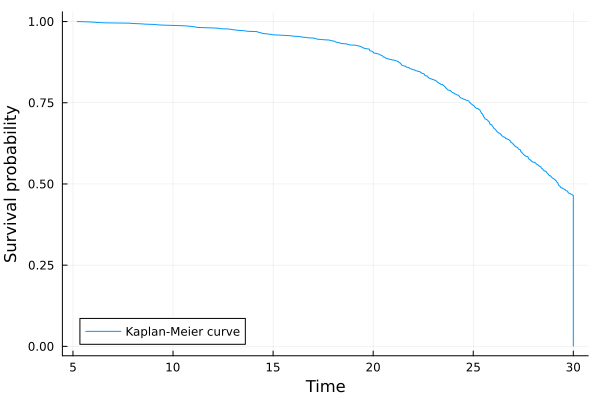

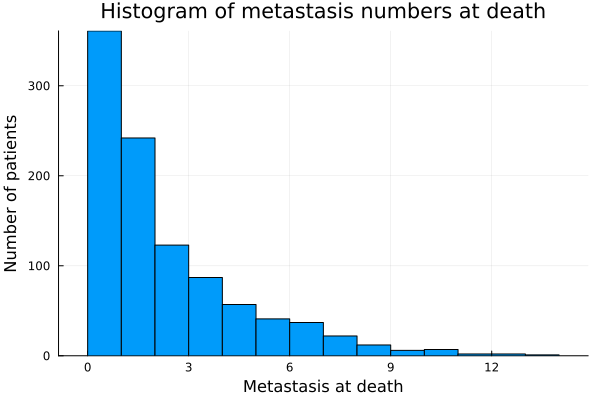

465 patients survived.

In [13]:
data_visualization(treated_data)

## Parameter Inference

In [14]:
using ForwardDiff
include("TherapyEffectLikelihoods.jl")
import .TherapyEffectLikelihoods as TL

In [17]:
using BenchmarkTools
using LatinHypercubeSampling

log_lb_x0 = [-0.75, -0.85, -1.9, -9, -9, -8, -8]
log_ub_x0 = [-0.65, -0.75, -1.4, -4, -4, -5, -5]

n_starts = 200 

# plan,_ = LHCoptim(n_starts, length(log_lb_x0), 1000)
# scaled_plan = scaleLHC(plan, [(log_lb_x0[i], log_ub_x0[i]) for i in eachindex(log_lb_x0)]);

# x0_vectors = [scaled_plan[i, :] for i in 1:size(scaled_plan, 1)];

# save startpoints
# save(joinpath(dir, "data/startpoints_treated_likelihoods_$(n_starts)_starts_$(θ).jld2"), "startpoints", x0_vectors)

x0_vectors = load(joinpath(dir, "data/startpoints_treated_likelihoods_$(n_starts)_starts_$(θ).jld2"))["startpoints"];

In [20]:
# optimization
x0 = x0_vectors[2]

OptimLlh(x, p) = TL.NegLogLikelihood(exp.(x), treated_data, S0=0.065)
OptimFunc = OptimizationFunction(OptimLlh, Optimization.AutoForwardDiff())
OptimProblem = OptimizationProblem(OptimFunc, x0, lb=log_lb_x0, ub=log_ub_x0)
joint_est = solve(OptimProblem, LBFGS(), maxiters=10^6, maxtime=600.0)
println("Joint Estimation:", joint_est, "\n")

Joint Estimation:retcode: Success
u: [-0.6925466567712698, -0.8055132472317532, -1.6158834745785147, -4.202390553896052, -5.775548111855563, -6.788717291251894, -6.677356761955562]
Final objective value:     63756.33855556089




In [541]:
# first we want to estimate only beta
betaOptim(x, p) = TL.TumorNegLogLikelihood(exp.(x[1:3]),treated_data, S0=S0)
betaOptimFunc = OptimizationFunction(betaOptim, Optimization.AutoForwardDiff())
betaOptimProblem = OptimizationProblem(betaOptimFunc, x0[1:3], lb=log_lb_x0[1:3], ub=log_ub_x0[1:3])
betaEst = solve(betaOptimProblem, LBFGS(), maxiters=10^5)
println("Beta:", exp.(betaEst), "\n")


In [552]:

# next we want to optimize the metastasis parameters
metOptim(x, p) = TL.MetastasisNegLogLikelihood(exp.([betaEst[1], betaEst[2], betaEst[3], x[1], x[2]]), treated_data, S0=S0)
metOptimFunc = OptimizationFunction(metOptim, Optimization.AutoForwardDiff())
metOptimProblem = OptimizationProblem(metOptimFunc, x0[4:5], lb=log_lb_x0[4:5], ub=log_ub_x0[4:5])
metEst = solve(metOptimProblem, LBFGS(), maxiters=10^5)
println("Metastasis:", metEst, "\n")

In [ ]:
deathOptim(x, p) = GL.DeathNegLogLikelihood([betaEst[1], betaEst[2], betaEst[3], metEst[1], metEst[2], x[1], x[2]], treated_data, S0=0.065)
deathOptimFunc = OptimizationFunction(deathOptim, Optimization.AutoForwardDiff())
deathOptimProblem = OptimizationProblem(deathOptimFunc, [0.005, 0.005], lb=zeros(2).+1e-4, ub=ones(2))
deathEst = solve(deathOptimProblem, LBFGS(), maxiters=10^6)
println("Death:", deathEst, "\n")
est_par = exp.([betaEst[1], betaEst[2], betaEst[3], metEst[1], metEst[2], deathEst[1], deathEst[2]]);

## Multi-Start

In [ ]:
optimizer = "LBFGS"
Llh_Type = "Analytic"
nstarts = 200
Analytic_result_path = joinpath(pwd(),"output/results/additive_treated_joined_optimization_$(nstarts)_starts_$(optimizer)_distributed_$(Llh_Type).jld2")
Analytic_results = load(Analytic_result_path)["results"]
Analytic_par_names = Analytic_results["par_names"]
Analytic_results = Analytic_results["optimization_results"]
Analytic_nllhs_list = [Analytic_results[i]["nllh"] for i in 1:nstarts]
failed_idxs = findall(isinf, Analytic_nllhs_list)
Analytic_par_list = [Analytic_results[i]["parameter"] for i in 1:nstarts][Not(failed_idxs)]
Analytic_mean_time = mean([Analytic_results[i]["time_trace"][end] for i in 1:nstarts][Not(failed_idxs)]) 
Analytic_max_time = maximum([Analytic_results[i]["time_trace"][end] for i in 1:nstarts][Not(failed_idxs)])

In [ ]:
Analytic_par_list[1]

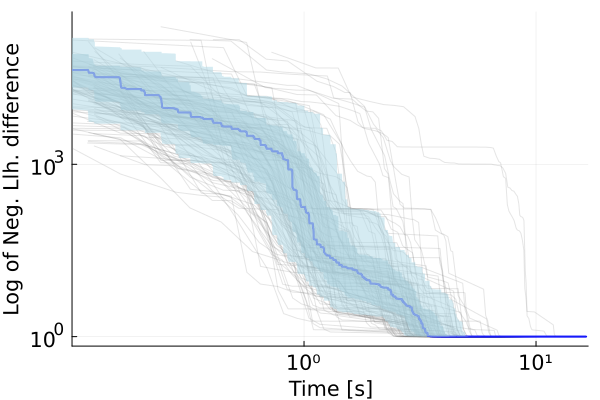

In [11]:
xlimits = (-1.0, log10(Analytic_max_time))
optimizer_trace_plots(Analytic_results, xlim=xlimits)
# savefig(joinpath(pwd(),"figures/ode_paper/traceplot_treated_$(nstarts)_starts_$(optimizer)_$(Llh_Type).pdf"))

In [10]:
optimizer = "LBFGS"
Llh_Type = "Analytic"
nstarts = 200
Analytic_result_path = joinpath(pwd(),"output/results/treated_joined_optimization_$(nstarts)_starts_$(optimizer)_distributed_$(Llh_Type).jld2")
Analytic_results = load(Analytic_result_path)["results"]
Analytic_par_names = Analytic_results["par_names"]
Analytic_results = Analytic_results["optimization_results"]
Analytic_nllhs_list = [Analytic_results[i]["nllh"] for i in 1:nstarts]
failed_idxs = findall(isinf, Analytic_nllhs_list)
Analytic_par_list = [Analytic_results[i]["parameter"] for i in 1:nstarts][Not(failed_idxs)]
Analytic_mean_time = mean([Analytic_results[i]["time_trace"][end] for i in 1:nstarts][Not(failed_idxs)]) 
Analytic_max_time = maximum([Analytic_results[i]["time_trace"][end] for i in 1:nstarts][Not(failed_idxs)])

┌ Warning: some parameters could not be resolved for type OptimizationForwardDiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, Main.TherapyLikelihoods.var"#Optim#76"{Float64, DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing},OptimizationBase.ReInitCache{Vector{Float64},SciMLBase.NullParameters}}; reading as OptimizationForwardDiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, Main.TherapyLikelihoods.var"#Optim#76"{Float64, DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Any}
└ @ JLD2 /home/vincent/.julia/packages/JLD2/bfPAo/src/data/reconstructing_datatype

472.908511292

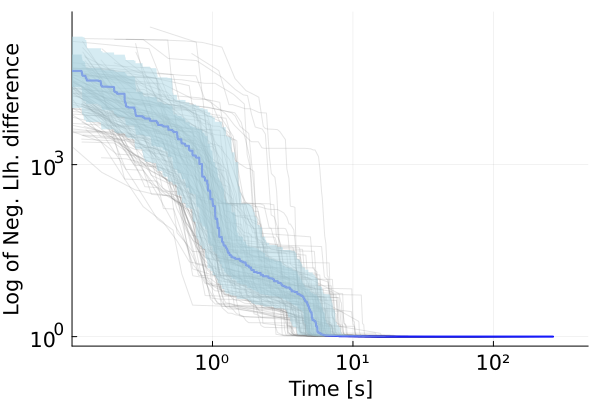

In [13]:
xlimits = (-1.0, log10(Analytic_max_time))
optimizer_trace_plots(Analytic_results, xlim=xlimits)
# savefig(joinpath(pwd(),"figures/ode_paper/traceplot_treated_$(nstarts)_starts_$(optimizer)_$(Llh_Type).pdf"))

In [21]:

filter!(x->x!=Inf, Analytic_nllhs_list)

123-element Vector{Float64}:
 32451.683320439835
 32451.683320441043
 32451.683320441625
 32451.68332044197
 32451.683320444652
 32451.683320444845
 32451.683320445
 32451.68332044526
 32451.68332044573
 32451.683320447068
     ⋮
 32451.683320473876
 32451.68332047407
 32451.68332047436
 32451.683320474756
 32451.683320474942
 32451.683320475713
 32451.683320476146
 32451.683320482338
 32451.683320482993

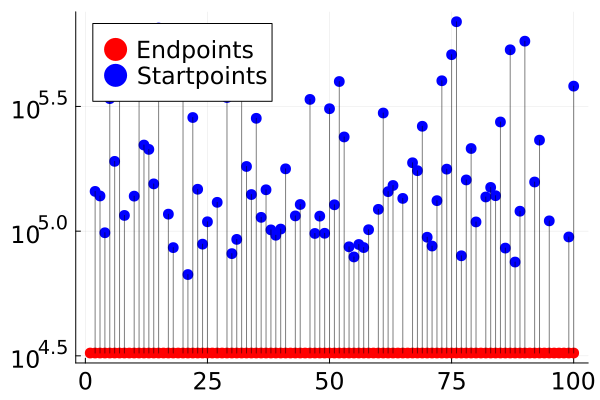

"/home/vincent/PhD/Projects/method_project/second_model/figures/ode_paper/double_waterfall_plot_treated_joined_optimisation_LBFGS_100_starts_Analytic.pdf"

In [24]:
optimizer = "LBFGS"
nstarts = 100
Llh_type = "Analytic"

# plot waterfall plot
x0_nllhs = [TL.NegLogLikelihood(exp.(x0_vectors[i]), treated_data, S0=0.065) for i in 1:n_starts];
cg = cgrad(:hsv, range(0, 1, length=nstarts))

filter!(x->x!=Inf, Analytic_nllhs_list)
perm = sortperm(Analytic_nllhs_list)
Analytic_nllhs_list .= Analytic_nllhs_list[perm]
Analytic_par_list .= Analytic_par_list[perm]

# set grouping by fval for color
rel_threshold = 1
k = 1
z = zeros(nstarts)
for i in 1:nstarts
    if i == 1
        z[i] = k
    else
        if Analytic_nllhs_list[i] - Analytic_nllhs_list[i-1] <= rel_threshold
            z[i] = k
        else
            k = k + 1
            z[i] = k
        end
    end
end

# cg = cgrad(:hsv, range(0, 1, length=Int(z[end])))
gr(markerstrokewidth=0,markersize=6)
plt = Plots.plot(Analytic_nllhs_list[1:nstarts], linecolor=:black,label=false,  yscale=:log10, legend=:best)
Plots.scatter!(plt, 1:1:nstarts, Analytic_nllhs_list[1:nstarts],  color=cg[Int.(z)], markershape=:circle, label="Endpoints")
scatter!(plt, 1:1:100, x0_nllhs, color=:blue, label="Startpoints")
for i in 1:nstarts
    plot!(plt, [i, i], [x0_nllhs[i], Analytic_nllhs_list[i]], color=:black, label=false, alpha=0.5)
end

plot!(plt, legendfontsize=16, tickfontsize=16, guidefontsize=16)
display(plt)

# savefig(joinpath(pwd(), "figures/ode_paper/double_waterfall_plot_treated_joined_optimisation_$(optimizer)_$(nstarts)_starts_$(Llh_type).pdf"))

# Sampling


In [257]:
using MCMCChains
using StatsPlots
using HDF5

In [604]:
niter = 2000
nchains = 4
init_par = [0.5, 0.45, 0.2];

# define negative loglikelihood
llh = p -> begin
    return -TLtest2.OnlyTumorNegLogLikelihood(p, tumor_data, S0=0.065)
end

# define bounds
log_lb_x0 = [-0.75, -0.85, -1.9]
log_ub_x0 = [-0.65, -0.75, -1.4]

insupport(θ) = all(θ .>= exp.(log_lb_x0)) && all(θ .<= exp.(log_ub_x0))

density(θ) = insupport(θ) ? llh(θ) : -Inf

model = DensityModel(density)

spl = RWMH(MvNormal(zeros(3), [0.005, 0.005, 0.005]))

# Sample from the posterior.
jlchain = sample(model, spl, MCMCThreads(), niter, nchains; param_names=["beta0" ,"rho", "delta"], initial_params=[θ_tumor,θ_tumor,θ_tumor,θ_tumor], chain_type=Chains)

complete_chain = set_section(jlchain, Dict(:parameters => [:beta0, :rho, :delta], :internals => [:lp]))



Chains MCMC chain (2000×4×4 Array{Float64, 3}):

Iterations        = 1:1:2000
Number of chains  = 4
Samples per chain = 2000
parameters        = beta0, rho, delta
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

       beta0    0.5002    0.0004    0.0000   108.2227   170.9131    1.0327     ⋯
         rho    0.4477    0.0017    0.0002    84.8196    86.9226    1.0688     ⋯
       delta    0.2011    0.0021    0.0002    72.0227    99.4385    1.0407     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       beta0    0.4993    0.4999    0.5001    0.5005    0.5012
         rho    0.4447    0.4462    0.4479    0.4487    0.4506
       delta    0.1970    0.1999    0.201

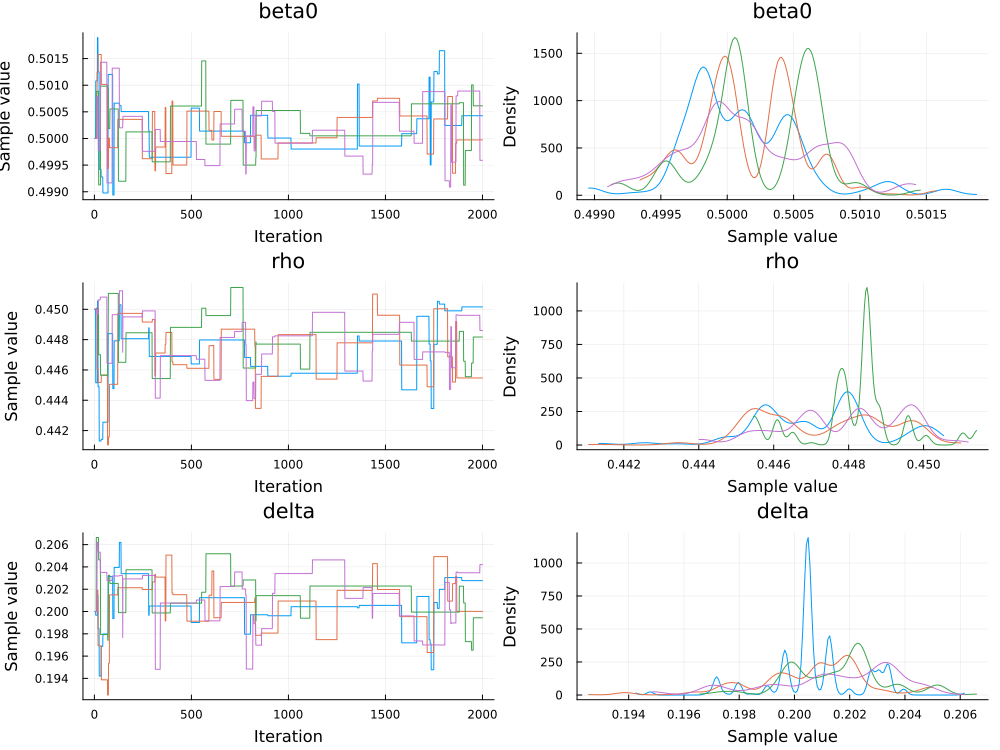

In [605]:
plot(complete_chain)

## Sampling


In [7]:
using MCMCChains
using MCMCChainsStorage
using StatsPlots
include("functionalities.jl")
using HDF5


In [93]:
# load result hdf5 file
n_iter = 50000
n_chains = 3
result_path = joinpath(pwd(), "output/simplified_model/sampling_treated_data_100p_$(n_chains)chs_$(n_iter)it_$(θ).h5")
chain_dict = h5open(result_path, "r") do file
    read(file,)
end
chain = dict_to_chain(chain_dict, ["beta", "rho", "delta", "m_basal", "m_size", "d_size", "d_metastasis"], n_chains, n_iter);

In [94]:
chain

Chains MCMC chain (50001×7×3 Array{Float64, 3}):

Iterations        = 1:1:50001
Number of chains  = 3
Samples per chain = 50001
parameters        = beta, rho, delta, m_basal, m_size, d_size, d_metastasis

Summary Statistics
    parameters      mean       std      mcse    ess_bulk     ess_tail      rha ⋯
        Symbol   Float64   Float64   Float64     Float64      Float64   Float6 ⋯

          beta    0.5003    0.0002    0.0000   4462.5062    6693.4080    1.001 ⋯
           rho    0.4494    0.0004    0.0000   3517.9211    2947.9486    1.002 ⋯
         delta    0.1992    0.0004    0.0000   3719.5538    3387.3606    1.001 ⋯
       m_basal    0.0133    0.0028    0.0001   2215.6256    1430.0165    1.006 ⋯
        m_size    0.0035    0.0003    0.0000   3660.5971    4868.1319    1.001 ⋯
        d_size    0.0012    0.0002    0.0000   5081.6279    6710.2940    1.001 ⋯
  d_metastasis    0.0040    0.0024    0.0000   3493.2269   10334.6109    1.002 ⋯
                                              

Some of the CIs do not cover the true parameter values unfortunately. But they are anyhow really really tight.

This might be due to the extra stochasticity in using covaraites, but I am wondering why this happens for the ODE parameters...

In [85]:
ex_par = mean(chain).nt.mean

7-element Vector{Float64}:
 0.5003188530866828
 0.44938562505464075
 0.19919058531688486
 0.013274581898550436
 0.0035145986188980104
 0.0011996497332672999
 0.0040311020705639175

In [90]:
TL.NegLogLikelihood(θ, treated_data, S0=0.065)

64593.32513716017

In [91]:
TL.NegLogLikelihood(ex_par, treated_data, S0=0.065)

64232.871844235684

In [10]:
burn_in = burn_in_from_geweke(chain)
if burn_in >= length(chain)
    burn_in = Int(floor(length(chain)/2))
end

25000

In [82]:
par_quantiles = quantile(chain[burn_in:end]; q=[0.01, 0.025, 0.05, 0.1, 0.5, 0.9, 0.95, 0.975, 0.99])

Quantiles
    parameters      1.0%      2.5%      5.0%     10.0%     50.0%     90.0%     ⋯
        Symbol   Float64   Float64   Float64   Float64   Float64   Float64   F ⋯

          beta    0.4999    0.5000    0.5000    0.5001    0.5003    0.5005     ⋯
           rho    0.4485    0.4487    0.4488    0.4489    0.4494    0.4498     ⋯
         delta    0.1982    0.1984    0.1985    0.1986    0.1992    0.1997     ⋯
       m_basal    0.0076    0.0084    0.0092    0.0100    0.0134    0.0171     ⋯
        m_size    0.0028    0.0029    0.0030    0.0031    0.0035    0.0039     ⋯
        d_size    0.0008    0.0009    0.0009    0.0010    0.0012    0.0014     ⋯
  d_metastasis    0.0002    0.0004    0.0006    0.0011    0.0039    0.0077     ⋯
                                                               3 columns omitted


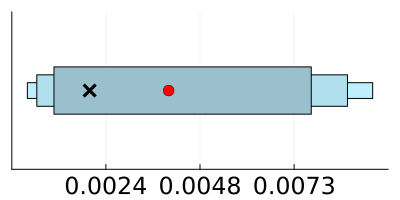

"/home/vincent/PhD/Projects/method_project/second_model/figures/ode_paper/treated_d_metastasis_estimate_cis.pdf"

In [102]:
par_id = 7
example_par = ex_par
true_par = [0.5, 0.45, 0.2, 0.01, 0.003, 0.001, 0.002]

plt = bar([0.5],
    [par_quantiles.nt[9][par_id]], 
    fillto=[par_quantiles.nt[3][par_id]], 
    xlimits=(par_quantiles.nt[2][par_id], par_quantiles.nt[10][par_id]),
    orientation=:h, 
    bar_width=0.1,
    color=:lightblue1,
    alpha=1.0, 
    label="95%CI")
bar!(plt, [0.5],
    [par_quantiles.nt[8][par_id]], 
    fillto=[par_quantiles.nt[4][par_id]], 
    xlimits=(par_quantiles.nt[2][par_id], par_quantiles.nt[10][par_id]),
    orientation=:h, 
    bar_width=0.2,
    color=:lightblue2,
    alpha=1.0, 
    label="90%CI")
bar!(plt, [0.5],
    [par_quantiles.nt[7][par_id]], 
    fillto=[par_quantiles.nt[5][par_id]], 
    xlimits=(par_quantiles.nt[2][par_id], par_quantiles.nt[10][par_id]),
    ylimits=(0.0, 1.0),
    orientation=:h, 
    bar_width=0.3,
    alpha=1.0, 
    color=:lightblue3,
    yticks=false,
    label="80%CI")
plot!([example_par[par_id]],[0.5], seriestype=:scatter, label="MLE", color=:red, markersize=6)
plot!([true_par[par_id]],[0.5], seriestype=:scatter, marker=:xcross, markerstrokewidth=8, label="True", color=:black, markersize=6)
x = true_par[par_id]
x_lower_limit = max(0, x-max(x-par_quantiles.nt[2][par_id], par_quantiles.nt[10][par_id]-x))
x_upper_limit = x+max(x-par_quantiles.nt[2][par_id], par_quantiles.nt[10][par_id]-x)
plot!(xlimits=(x_lower_limit, x_upper_limit))
x_ticks = LinRange(x_lower_limit, x_upper_limit, 5)[2:end-1]
plot!(xticks = (x_ticks, round.(x_ticks, digits=4)))
plot!(size=(400, 200), formatter=:plain, legend=false, tickfontsize=16, legendfontsize=16, guidefontsize=16)
display(plt)
savefig("figures/ode_paper/treated_$(treated_par_names[par_id])_estimate_cis.pdf")
